In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# from mpl_toolkits.basemap import basemap

In [2]:
hdpd = pd.read_csv('points_with_gridIds_reLabel.csv')
hd = pd.DataFrame.to_xarray(hdpd)
hd
# hd.groupby('index.key')
print(hdpd.groupby(by = 'key', axis = 1))

In [3]:
# forCount = hdpd['month','key']
size = hd.groupby('key').count()
# bigs = size.keys()
# bigs.values
sorted = size.sortby('day', ascending = False)
sorted.key[:10]

<xarray.DataArray 'key' (key: 10)>
array(['             NADINE-2012', '               KYLE-2002',
       '             LESLIE-2018', '               JOSE-2017',
       '           FLORENCE-2018', '            MARILYN-1995',
       '               IVAN-2004', '            ALBERTO-2000',
       '             HARVEY-2017', '           NICHOLAS-2003'], dtype=object)
Coordinates:
  * key      (key) object '             NADINE-2012' ... '           NICHOLAS...

In [4]:
hd['Lon'] = -1*hd['Lon']

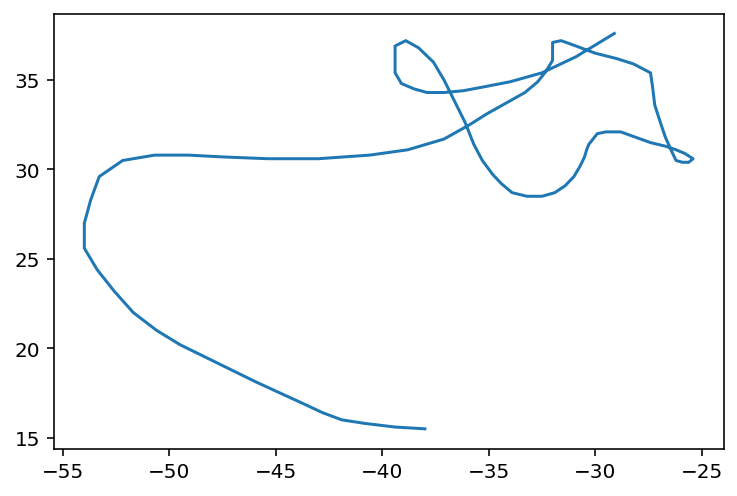

In [5]:
j = hd.get(['key', 'Lat', 'Lon'])
nad = j.where(j['key'] == sorted.key[0], drop = True)
# lat = nad['Lat'].values
# lon = nad['Lon'].values
# lon = [x * -1 for x in lon]
# xpt

plt.plot(nad['Lon'].values, nad['Lat'].values)

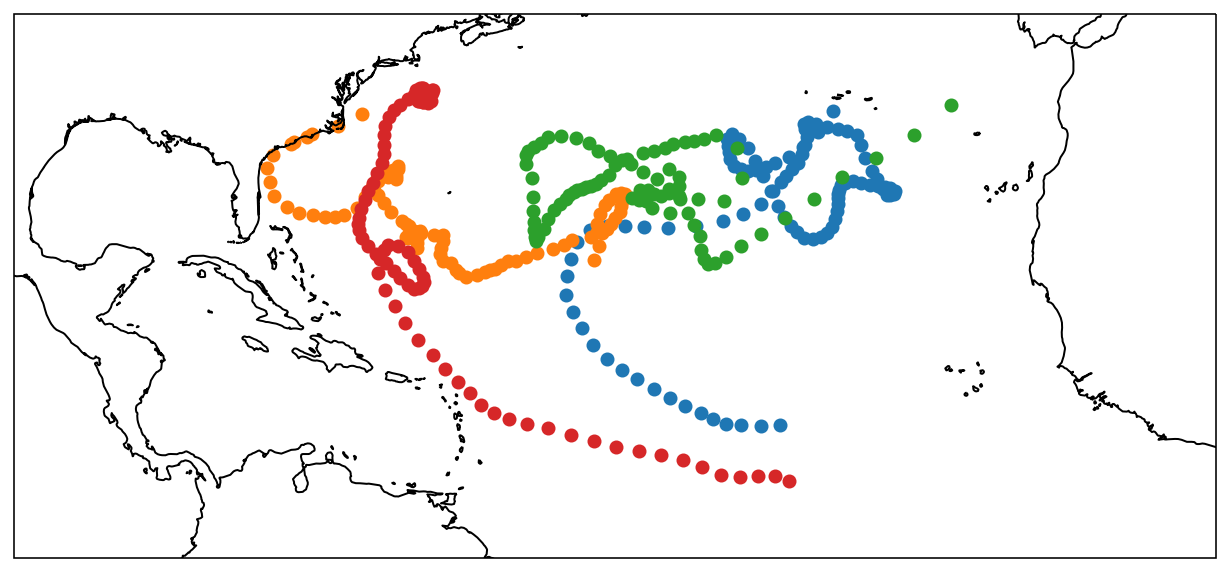

In [6]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

two = j.where(j['key'] == sorted.key[1], drop = True)
thr = j.where(j['key'] == sorted.key[2], drop = True)
fr = j.where(j['key'] == sorted.key[3], drop = True)



nad.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
two.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
thr.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
fr.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
ax.coastlines();
ax.set_extent(extent)

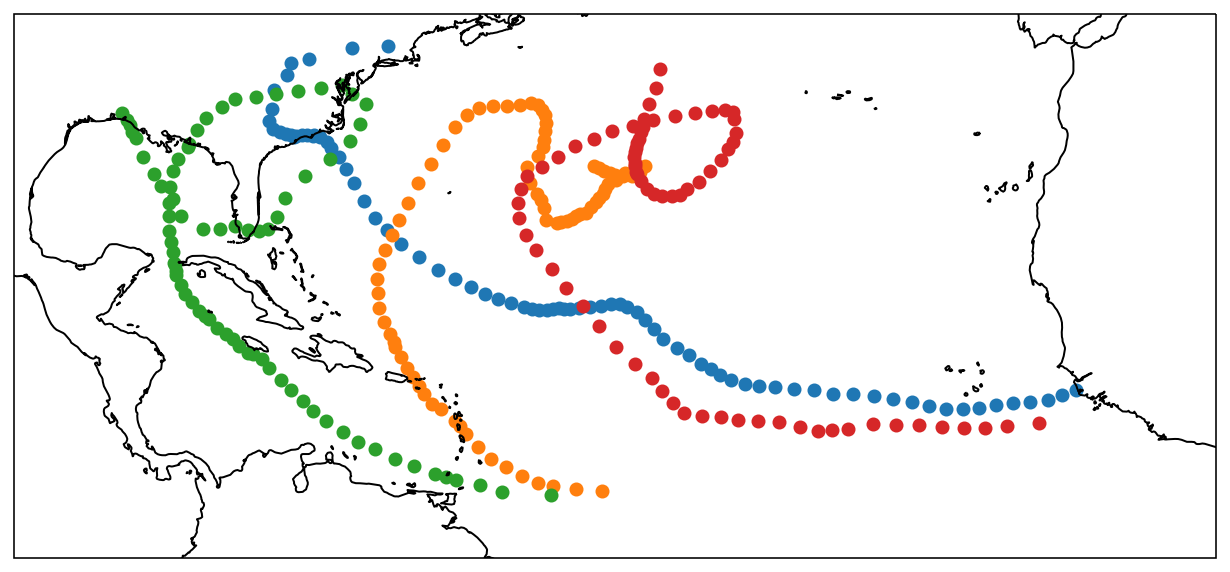

In [7]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

fv = j.where(j['key'] == sorted.key[4], drop = True)
sx = j.where(j['key'] == sorted.key[5], drop = True)
sv = j.where(j['key'] == sorted.key[6], drop = True)
et = j.where(j['key'] == sorted.key[7], drop = True)



fv.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
sx.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
sv.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
et.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)
ax.coastlines();
ax.set_extent(extent)

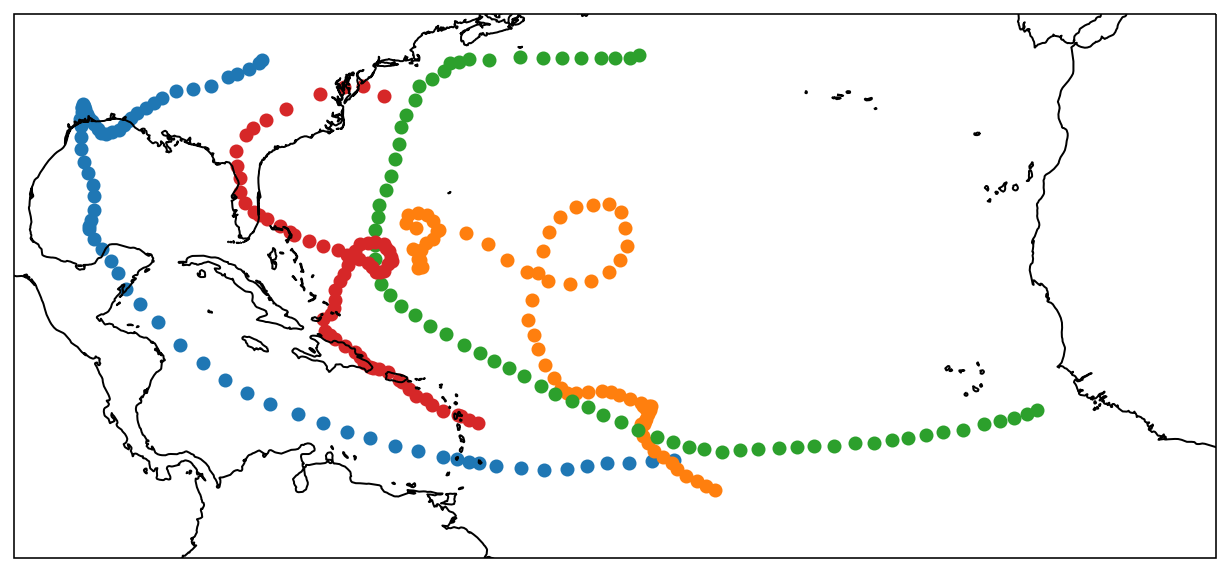

In [8]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

for i in range(8,12):
    th = j.where(j['key'] == sorted.key[i], drop = True)
    th.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)

ax.coastlines();
ax.set_extent(extent)

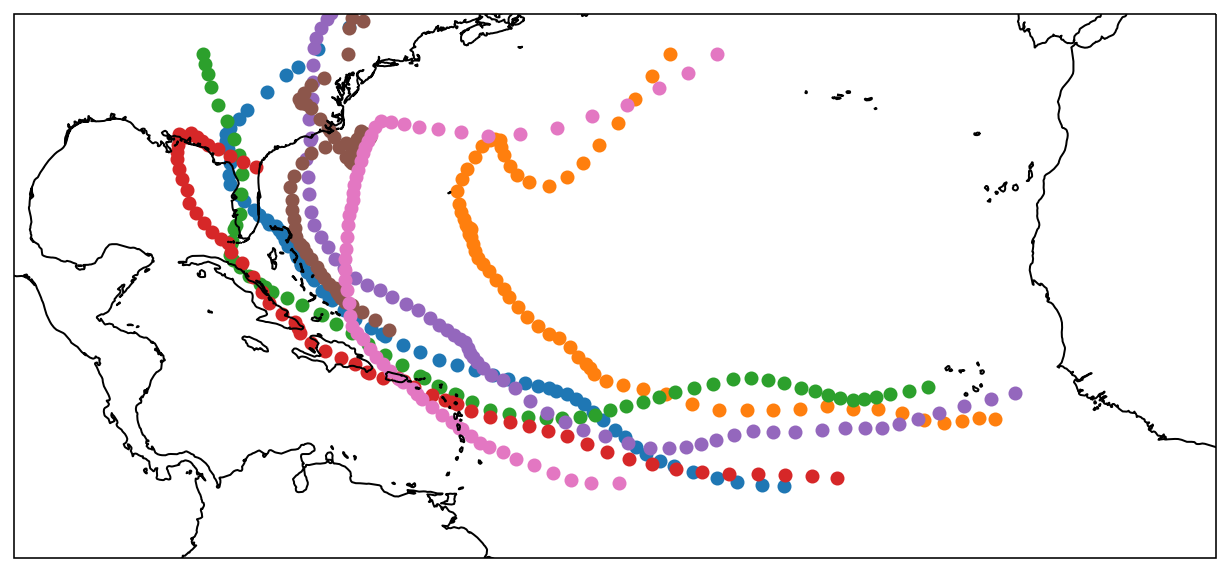

In [9]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

for i in range(13,20):
    th = j.where(j['key'] == sorted.key[i], drop = True)
    th.plot.scatter(x = 'Lon', y = 'Lat',transform=proj_dta, ax = ax)

ax.coastlines();
ax.set_extent(extent)

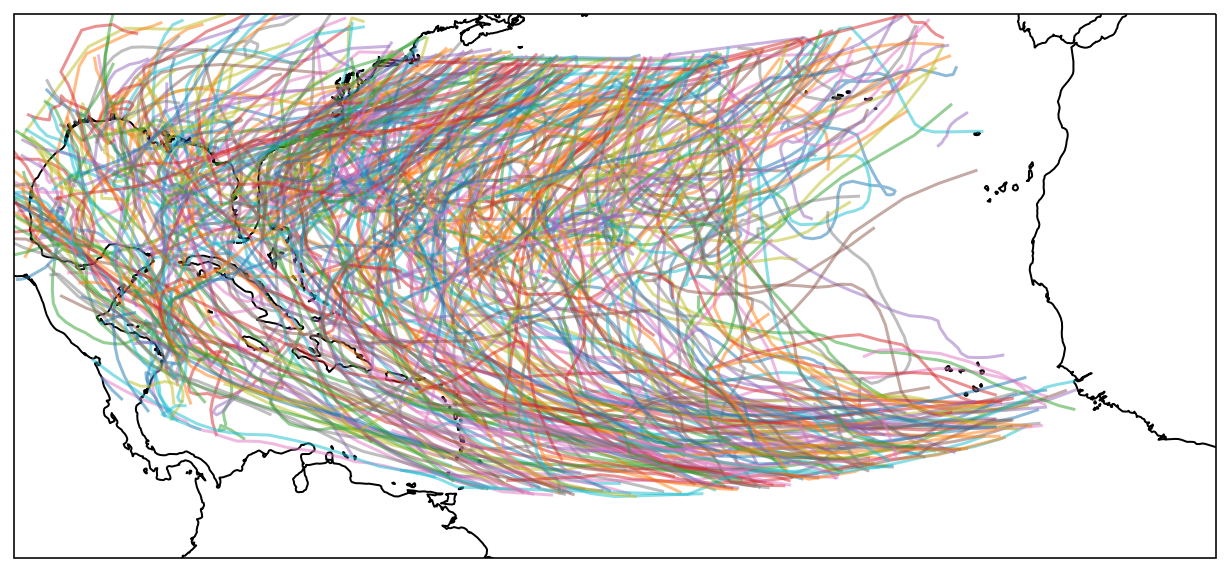

In [10]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

for i in range(0,481):
    th = j.where(j['key'] == sorted.key[i], drop = True)
    plt.plot(th['Lon'].values, th['Lat'].values, transform=proj_dta, alpha = 0.5)

ax.coastlines();
ax.set_extent(extent)

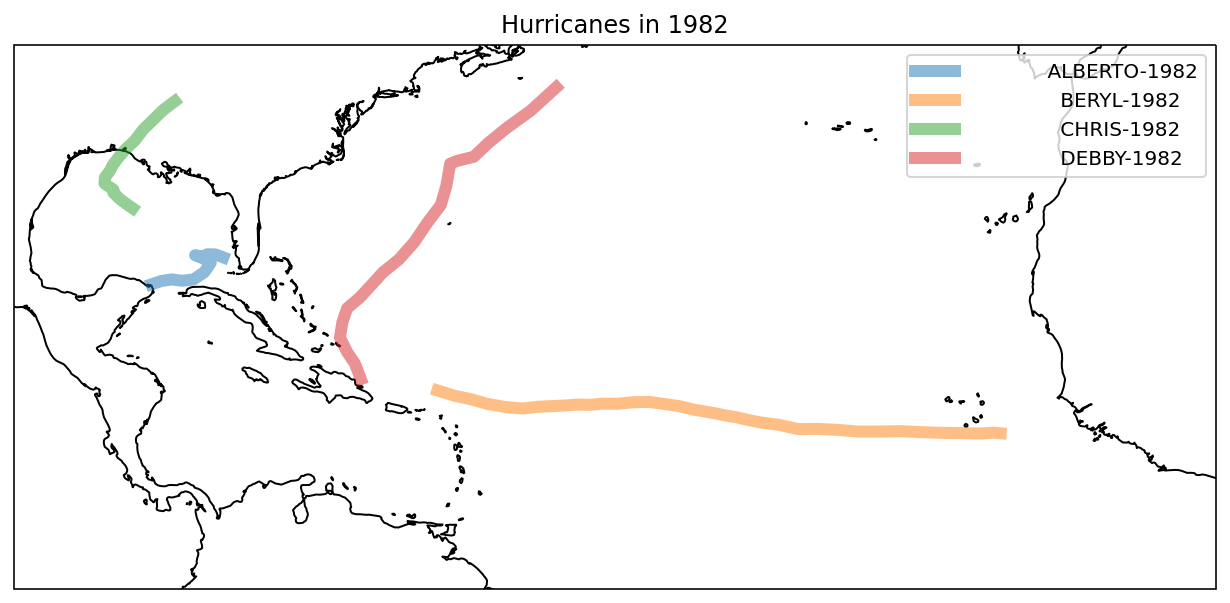

In [11]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

# myYear = hd.where(hd['key'].values[-4:] == 1990, drop = True)

myindices = []

year = '1982'

for i in range(len(hd['key'])):
    if hd['key'].values[i][-4:] == year:
        myindices.append(i)
# selYear = hd[myindices]

# size = selYear.groupby('key').count()

# for i in range(len(selYear)):
#     th = selYear.where(selYear['key'] == size.key[i], drop = True)
#     plt.plot(th['Lon'].values, th['Lat'].values, transform=proj_dta, alpha = 0.5)
    


hd['key'][myindices]
shortInd = []
for i in hd['key'][myindices]:
    if i not in shortInd:
        shortInd.append(i)

for i in range(len(shortInd)):
    selHur = hd.where(hd['key'] == shortInd[i], drop = True)
    plt.plot(selHur['Lon'].values, selHur['Lat'].values, transform=proj_dta, linewidth = 6, alpha = 0.5, label = shortInd[i].values)
    
ax.set_title("Hurricanes in {}".format(year))
ax.coastlines();
ax.set_extent(extent)
ax.legend()

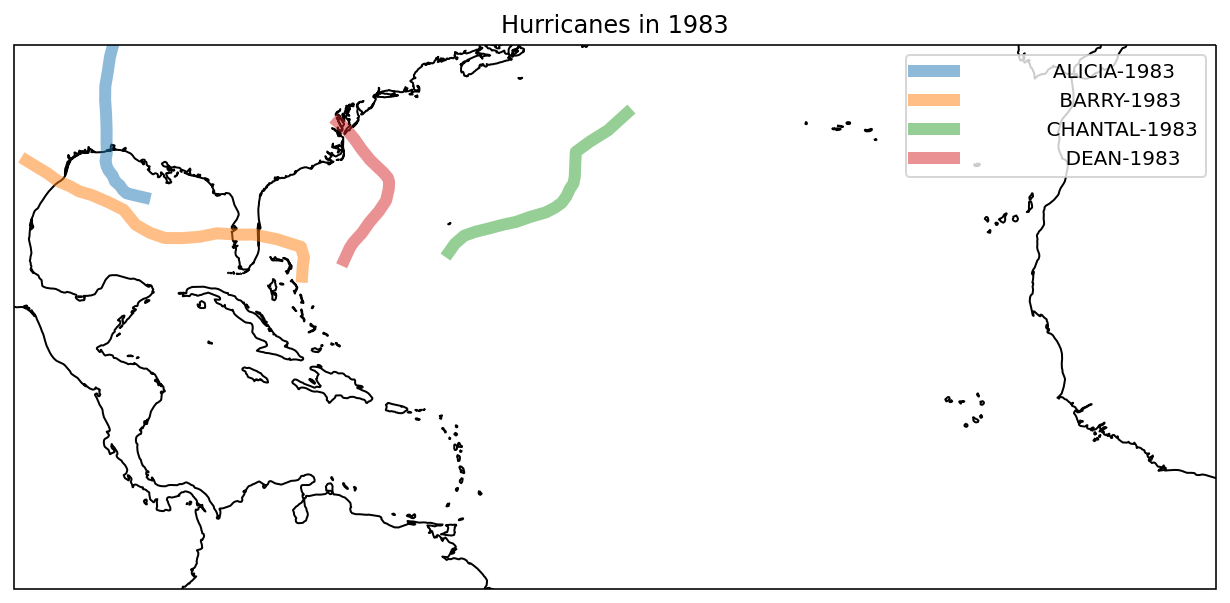

In [12]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)
extent = [-90, -10, 5, 40]
myindices = []

year = '1983'
for i in range(len(hd['key'])):
    if hd['key'].values[i][-4:] == year:
        myindices.append(i)

hd['key'][myindices]
shortInd = []
for i in hd['key'][myindices]:
    if i not in shortInd:
        shortInd.append(i)

for i in range(len(shortInd)):
    selHur = hd.where(hd['key'] == shortInd[i], drop = True)
    plt.plot(selHur['Lon'].values, selHur['Lat'].values, transform=proj_dta, linewidth = 6, alpha = 0.5, label = shortInd[i].values)
    
ax.set_title("Hurricanes in {}".format(year))
ax.coastlines();
ax.set_extent(extent)
ax.legend()

<Figure size 864x360 with 0 Axes>

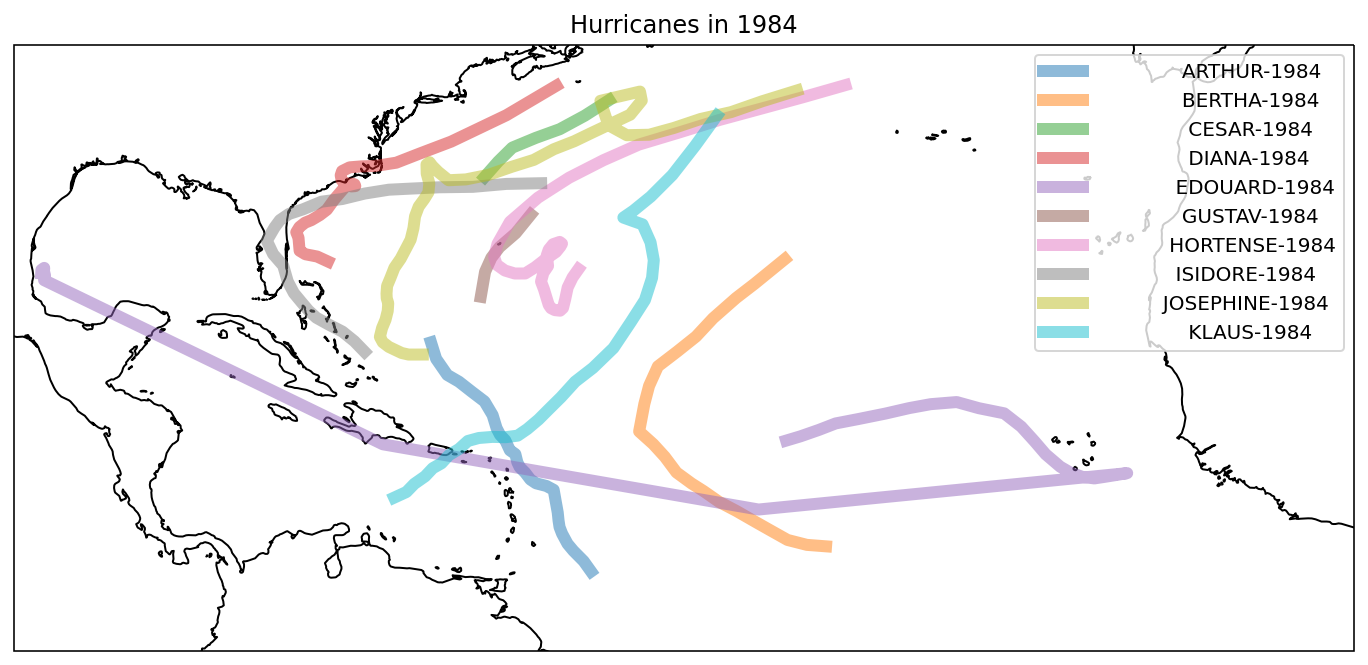

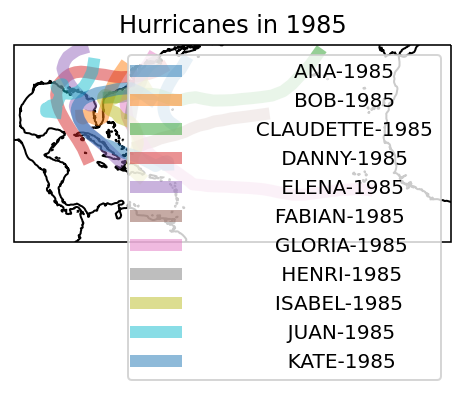

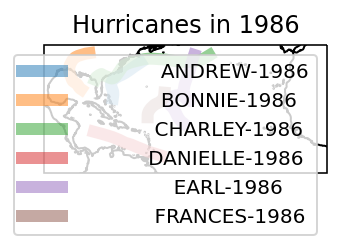

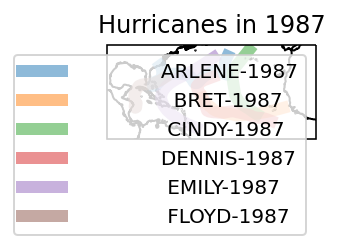

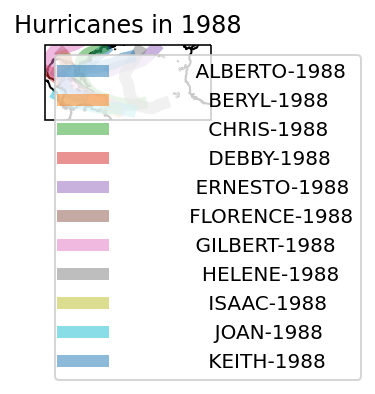

In [ ]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection
fig = plt.figure(figsize=(12,5))
# ax = plt.subplot(projection=proj_map)

# ax = plt.subplot(37, 1, 1, projection = proj_map)
extent = [-90, -10, 5, 40]


fig = plt.figure(figsize=(12,185))
for i in range(1984,2020):
    myindices = []
    
    
    
    ax = plt.subplot(i-1983, 1, 1, projection = proj_map)

    year = str(i)
    for i in range(len(hd['key'])):
        if hd['key'].values[i][-4:] == year:
            myindices.append(i)

    hd['key'][myindices]
    shortInd = []
    for i in hd['key'][myindices]:
        if i not in shortInd:
            shortInd.append(i)

    for i in range(len(shortInd)):
        selHur = hd.where(hd['key'] == shortInd[i], drop = True)
        plt.plot(selHur['Lon'].values, selHur['Lat'].values, transform=proj_dta, linewidth = 6, alpha = 0.5, label = shortInd[i].values)

    ax.set_title("Hurricanes in {}".format(year))
    ax.coastlines();
    ax.set_extent(extent)
    ax.legend()
    plt.show()

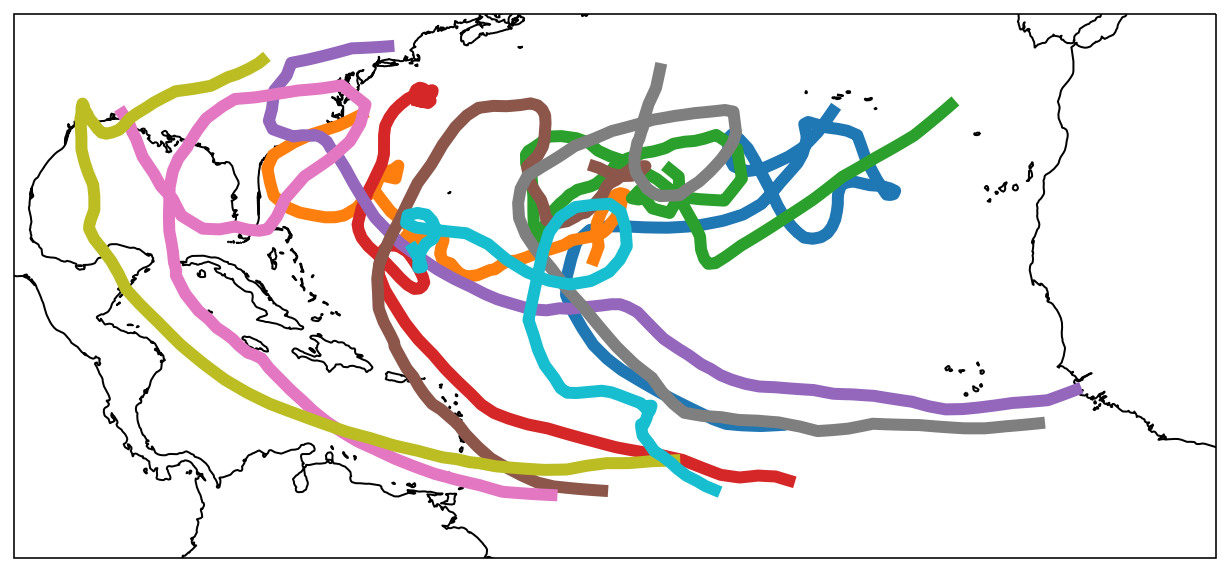

In [91]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

for q in range(0,10):
    this = j.where(j['key'] == sorted.key[q], drop = True)
    lonlist = np.empty((len(this.Lon)-1) * 100)
    latlist = np.empty((len(this.Lat)-1) * 100)
    # for i in len(range(nad.index)):

    for i in range(len(this.Lat)-1):
        latlist[100*i:100+100*i] = np.linspace(this.Lat[i], this.Lat[i+1], 100)

    for i in range(len(this.Lon)-1):
        lonlist[100*i:100+100*i] = np.linspace(this.Lon[i], this.Lon[i+1], 100)

    # plt.plot(lonlist, latlist)
    # plt.show()



    mydat = np.array((lonlist, latlist))

    plt.plot(lonlist, latlist, transform = proj_dta, linewidth = 6)
# pan = pd.DataFrame(data=mydat)
# bx = pd.DataFrame.to_xarray(pan)

# bx.plot.scatter(x = 'Lon', y = 'Lat', transform=proj_dta, ax = ax)

ax.coastlines();
ax.set_extent(extent)

plt.show()

In [92]:
onlybigs = hd.where(hd['key'] == sorted.key[0], drop = True)
onlybigs.plot.line(x = Lat, y = Lon)

AttributeError: '_Dataset_PlotMethods' object has no attribute 'line'

In [93]:
bignames = np.array(bigs)
hdbigs = hdpd.where(hdpd['key'] == bigs.any())
hdbigs[hdbigs.notnull()]

NameError: name 'bigs' is not defined

In [14]:
# keys = hdpd['key']

In [15]:
# grouped = hdpd.groupby('key')
# grouped.groups.keys()
# for key in keys:
#     grouped.count()

In [16]:
g = hd.groupby('key')

In [17]:
g.count()

<xarray.Dataset>
Dimensions:     (key: 482)
Coordinates:
  * key         (key) object '                ANA-1985' ... '         TWENTY-...
Data variables:
    Unnamed: 0  (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    month       (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    day         (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Date        (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Class       (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Lat         (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Lon         (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Max wind    (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    Min pres    (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    SST         (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    UWND        (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    VWND        (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    rhum        (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    airtemp     (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    distance    (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    direction   (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27
    gridID      (key) int64 13 25 19 39 26 28 21 26 ... 52 62 21 9 33 19 25 27

In [18]:
n = 5
n = Basemap(llcrnrlon = -110., llcrnrlat = 5., urcrlon = 10., urcrlat = 60.,
           rsphere = (6378137.00, 6356752.3142),
           resolution = '1',
           projection = 'merc',
           lat_0 = 40.0, lon_0 = -20., lat_ts = 20.))

SyntaxError: unmatched ')' (<ipython-input-18-f2f21cc2b379>, line 6)